In [47]:
%load_ext autoreload
%autoreload 2
# %config Application.verbose_crash=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os
from src.dataclasses.transactions import Transactions
from src.dataclasses.ticker import Ticker
from src.dataclasses.holdings import Holdings
from src.dataclasses.prices import Prices
from src.dataclasses.subscriptions import Subscriptions

from src.utils.defaults import DEFAULT_RFR

## Load in subscriptions

In [49]:
subscriptions = Subscriptions.from_csv(os.getcwd() + "/data/subscriptions.csv")
subscriptions.data.head()

,Portfolio,GBP,USD
Date,,,
2022-02-09,LISA,2003.15,2713.780671
2022-02-10,0,0.00,0.000000
2022-02-11,0,0.00,0.000000
2022-02-12,0,0.00,0.000000
2022-02-13,0,0.00,0.000000


## Load in transactions

In [50]:
transactions = Transactions.from_csv(os.getcwd() + "/data/full_transaction_history.csv")
transactions.raw_data.head()

,Portfolio,Date,Transaction,Description,Quantity,Price,Ticker
0,LISA,2022-02-09,Purchase,GameStop Corp Class A,82,24.13,GME
1,ISA,2022-04-11,Purchase,iShares Core S&P 500 ETF USD Acc GBP,8,345.20,CSP1.L
2,LISA,2022-05-10,Purchase,GameStop Corp Class A,42,23.09,GME
3,ISA,2022-05-12,Purchase,iShares Core S&P 500 ETF USD Acc GBP,5,342.01,CSP1.L
4,LISA,2022-08-23,Purchase,GameStop Corp Class A,32,30.00,GME


In [51]:
Ticker("GBPUSD=X", is_fx=True).prices.tail()

Date
2025-11-13    1.312784
2025-11-14    1.315218
2025-11-15    1.315218
2025-11-16    1.315218
2025-11-17    1.315097
Freq: D, Name: GBPUSD=X, dtype: float64

In [52]:
from concurrent.futures import ThreadPoolExecutor


pool = ThreadPoolExecutor(max_workers=10)
prices = Prices(transactions=transactions, pool=pool)
prices.data.tail()

Loading prices:   0%|          | 0/11 [00:00<?, ?it/s]

Loading prices: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


,GOOG,AMZN,MU,AAPL,META,GME,ORCL,VUSA.L,DJEL.L,CSP1.L,GXLK.L
Date,,,,,,,,,,,
2025-11-13,279.119995,237.580002,236.949997,272.950012,609.890015,20.959999,217.570007,127.927506,482.809076,721.558508,152.978699
2025-11-14,276.980011,234.690002,246.830002,272.410004,609.460022,20.660000,222.850006,128.046366,479.166918,722.370515,154.735438
2025-11-15,276.980011,234.690002,246.830002,272.410004,609.460022,20.660000,222.850006,128.046366,479.166918,722.370515,154.735438
2025-11-16,276.980011,234.690002,246.830002,272.410004,609.460022,20.660000,222.850006,128.046366,479.166918,722.370515,154.735438
2025-11-17,284.859985,230.979996,242.007996,266.519592,598.288208,20.355000,216.448196,127.288272,476.130989,718.148351,152.498685


In [53]:
prices.data.index

DatetimeIndex(['2015-11-17', '2015-11-18', '2015-11-19', '2015-11-20',
               '2015-11-21', '2015-11-22', '2015-11-23', '2015-11-24',
               '2015-11-25', '2015-11-26',
               ...
               '2025-11-08', '2025-11-09', '2025-11-10', '2025-11-11',
               '2025-11-12', '2025-11-13', '2025-11-14', '2025-11-15',
               '2025-11-16', '2025-11-17'],
              dtype='datetime64[ns]', name='Date', length=3654, freq='D')

In [54]:
holdings = Holdings(
    transactions=transactions, prices=prices, subscriptions=subscriptions
)

<Axes: >

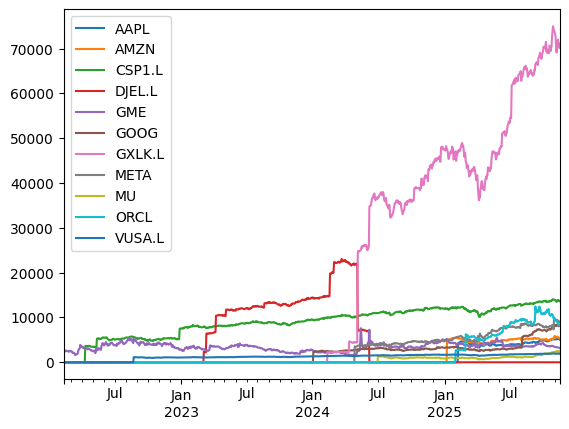

In [55]:
holdings.data.plot()

<Axes: xlabel='Date'>

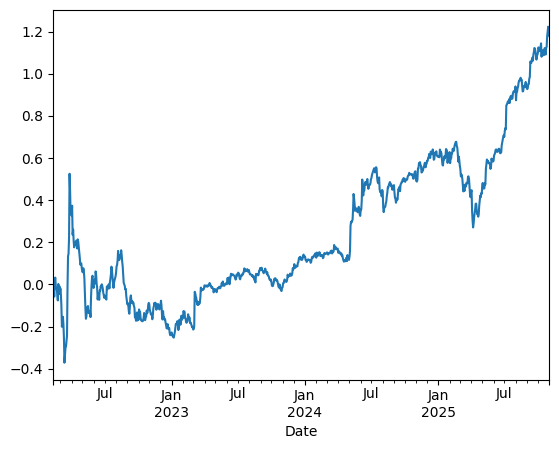

In [56]:
holdings.twr.add(1).cumprod().sub(1).plot()
# holdings.twr[holdings.twr > 0.1].resample("D").sum().fillna(0).plot()

In [57]:
holdings.transactions.data

Ticker,AAPL,AMZN,CSP1.L,DJEL.L,GME,GOOG,GXLK.L,META,MU,ORCL,VUSA.L
2022-02-09,0.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Date'>

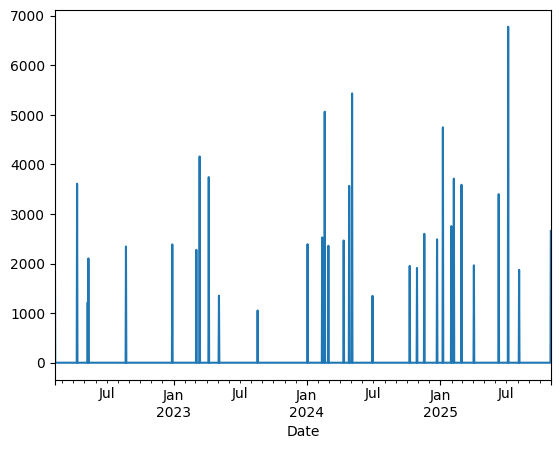

In [58]:
holdings.subscriptions.data["USD"].resample("D").sum().fillna(0).plot()

<Axes: xlabel='Date'>

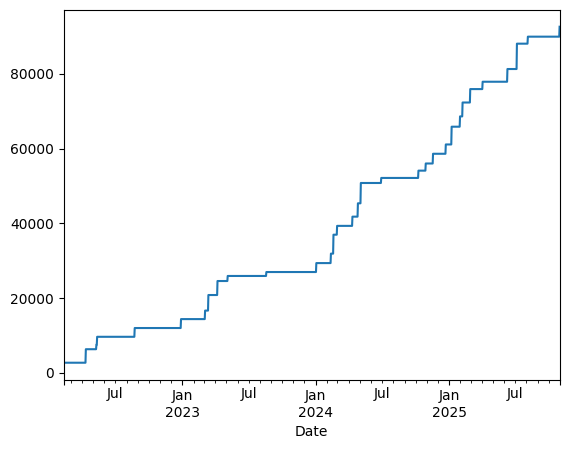

In [59]:
holdings.subscriptions.data["USD"].resample("D").sum().cumsum().fillna(0).plot()

<Axes: >

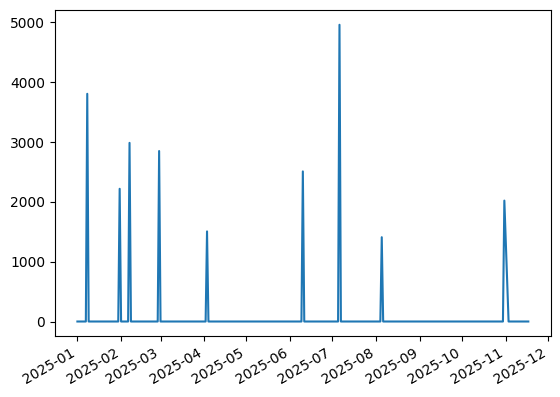

In [60]:
cfs = (
    holdings.subscriptions.data["GBP"]
    # .resample("D")
    # .sum()  # in case of multiple deposits per day
    .reindex(holdings.total.index.union(holdings.subscriptions.data.index))
    .fillna(0.0)
)

cfs["2025":].plot()

In [61]:
holdings.subscriptions.data["GBP"].max()

np.float64(4960.57)

In [62]:
subscriptions.data

,Portfolio,GBP,USD
Date,,,
2022-02-09,LISA,2003.15,2713.780671
2022-02-10,0,0.00,0.000000
2022-02-11,0,0.00,0.000000
2022-02-12,0,0.00,0.000000
2022-02-13,0,0.00,0.000000
...,...,...,...
2025-10-27,0,0.00,0.000000
2025-10-28,0,0.00,0.000000
2025-10-29,0,0.00,0.000000


<Axes: >

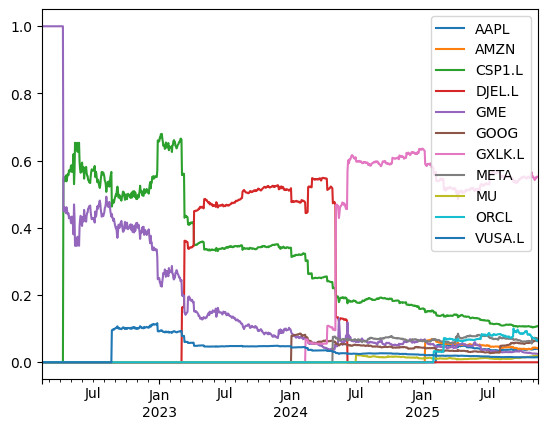

In [63]:
holdings.weights.plot()

In [87]:
bmk = Ticker("^SPX").returns

In [88]:
from src.dataclasses.assessment_config import AssessmentConfig


config = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,
    bmk=bmk,
)

In [206]:
import requests
import pandas as pd

# Example series
returns = pd.Series([0.01, -0.02, 0.015, 0.005])
bmk = pd.Series([0.009, -0.018, 0.014, 0.004])
rfr = pd.Series([0.009, -0.018, 0.014, 0.004])

payload = {
    "assessment": "beta",
    "type": "summary",
    "returns": returns.to_list(),  # convert Series → list
    "bmk": bmk.to_list(),  # convert Series → list
    "rfr": rfr.to_list(),  # convert Series → list
    # "kwargs": {}
}

res = requests.post("http://localhost:8000/run", json=payload)
print(res.json())

{'job_id': 'af387f7e-57a9-432a-8f7e-0fedbb6f677d'}


'{"0":0.009,"1":-0.018,"2":0.014,"3":0.004}'

In [192]:
from src.assessments.beta import Beta
from src.utils.executors import RQExecutor

# Example data
returns_list = [0.01, 0.02, 0.015]
bmk_list = [0.012, 0.018, 0.014]
rfr_list = [0.012, 0.018, 0.014]

# API executor pointing to your FastAPI + RQ server
executor = RQExecutor("http://localhost:8000")

# Submit a Beta assessment
future = executor.submit(
    assessment_name="Beta",
    config_kwargs={"returns": returns_list, "bmk": bmk_list, "rfr": rfr_list},
    assessment_type="summary",
)

# Block until result
result = future.result(timeout=30)
print(result)

RuntimeError: Job bb462c67-b7d2-49d6-a785-40915a818557 failed

In [218]:
# %tb
from src.evaluation import Evaluation, ExecutorType

# executor = ExecutorType.DEFAULT()
# executor = ExecutorType.ProcessPool(max_workers=8)

# from src.app.task_queue import task_queue
executor = ExecutorType.Remote("http://localhost:8000")


f = (
    Evaluation(config)
    # .with_assessment_types(["summary"]).with_assessments(["Beta"])
    # .with_pool(Pool.ProcessPool)
    # .with_assessments([AssessmentName.Beta])
    # .with_assessment_types(["rolling"])
    .with_executor(executor=executor)
    .run()
)


f._results

2025-11-18 02:21:52 INFO [src.<string>] Using RQExecutor


{<AssessmentName.Beta: 'Beta'>: {<AssessmentType.Summary: 'summary'>: 0.921766403304964,
  <AssessmentType.Rolling: 'rolling'>: Date
  2022-02-10         NaN
  2022-02-11         NaN
  2022-02-14         NaN
  2022-02-15         NaN
  2022-02-16         NaN
                  ...   
  2025-10-27    0.665512
  2025-10-28    0.664721
  2025-10-29    0.664596
  2025-10-30    0.668766
  2025-10-31    0.668374
  Freq: B, Length: 972, dtype: float64,
  <AssessmentType.Expanding: 'expanding'>: Date
  2022-02-10         NaN
  2022-02-11         NaN
  2022-02-14         NaN
  2022-02-15         NaN
  2022-02-16         NaN
                  ...   
  2025-10-27    0.921010
  2025-10-28    0.921128
  2025-10-29    0.921090
  2025-10-30    0.921860
  2025-10-31    0.921766
  Freq: B, Length: 972, dtype: float64},
 <AssessmentName.CAGR: 'CAGR'>: {<AssessmentType.Summary: 'summary'>: 0.22390064970150858,
  <AssessmentType.Rolling: 'rolling'>: Date
  2022-02-10         NaN
  2022-02-11         NaN
  2

In [137]:
ExecutorType.DEFAULT(None)

In [117]:
Pool.DEFAULT.value(max_workers=8)

In [67]:
f.timer()

,Assessment,Type,Time (s)
0,Beta,summary,0.001660
1,Beta,rolling,0.001715
2,Beta,expanding,0.000351
3,CAGR,summary,0.000084
4,CAGR,rolling,0.002327
5,CAGR,expanding,0.003304
6,Max Drawdown,summary,0.000751
7,Max Drawdown,rolling,0.004862
8,Max Drawdown,expanding,0.009697
9,Tracking Error,summary,0.000124


In [68]:
# Had more capital and more focused on active mgmt
# (switched away from majority holding in DOW)
config_active = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,  # 3mo US Tresury
    bmk=bmk,  # SP500
    start="2024",
)

f_active = Evaluation(config_active).run()
# pd.Series(f_active.results)

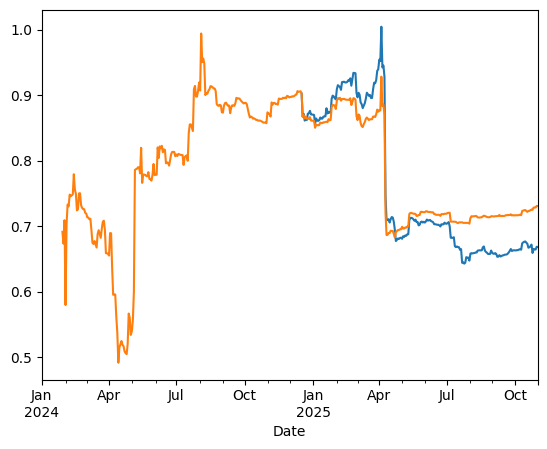

In [69]:
beta = Beta(config=config_active)


x = beta.summary()
x = beta.rolling().plot()
x = beta.expanding().plot()

# x.plot()
# bmk["2025":].add(1).cumprod().plot()
# beta.run("summary")
# beta.timer.df

#

<Axes: xlabel='Date'>

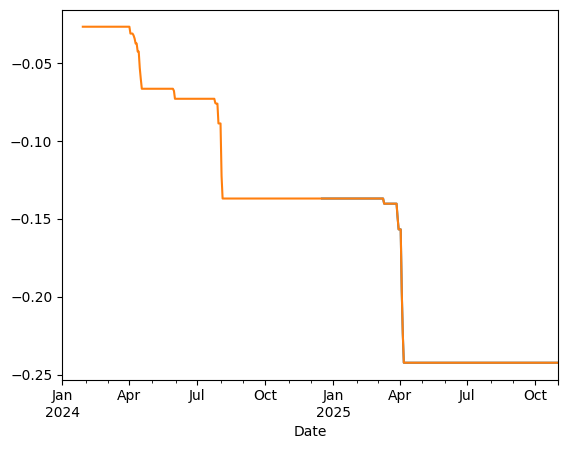

In [70]:
from src.assessments.max_drawdown import MaxDrawdown

max_dd = MaxDrawdown(config=config_active)
max_dd.summary()
max_dd.rolling().plot()
max_dd.expanding().plot()
# max_dd.results

<Axes: xlabel='Date'>

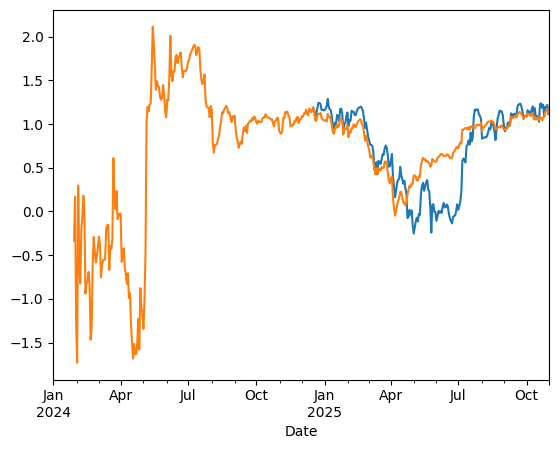

In [71]:
from src.assessments.sharpe_ratio import SharpeRatio

max_dd = SharpeRatio(config=config_active)
max_dd.summary()
max_dd.rolling().plot()
max_dd.expanding().plot()
# max_dd.results

<Axes: xlabel='Date'>

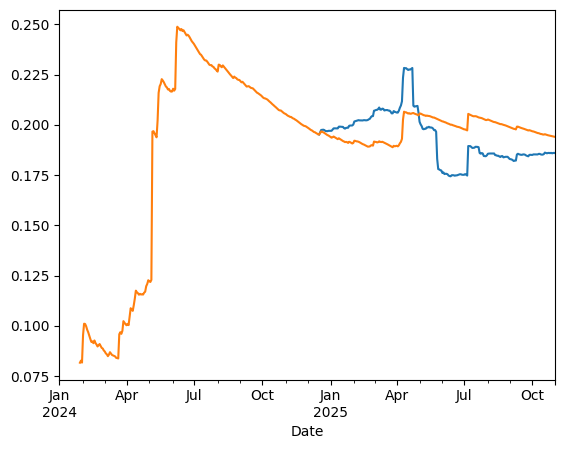

In [72]:
from src.assessments.tracking_error import TrackingError

tracking_error = TrackingError(config=config_active)
# tracking_error.summary()
tracking_error.rolling().plot()
tracking_error.expanding().plot()
# tracking_error.results

<Axes: xlabel='Date'>

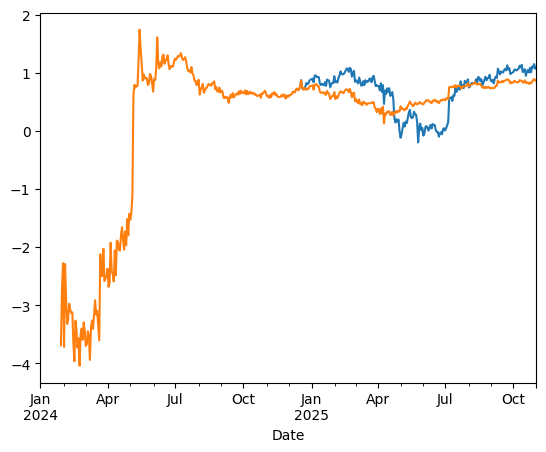

In [73]:
from src.assessments.information_ratio import InformationRatio

information_ratio = InformationRatio(config=config_active)
information_ratio.summary()
information_ratio.rolling().plot()
information_ratio.expanding().plot()

<Axes: xlabel='Date'>

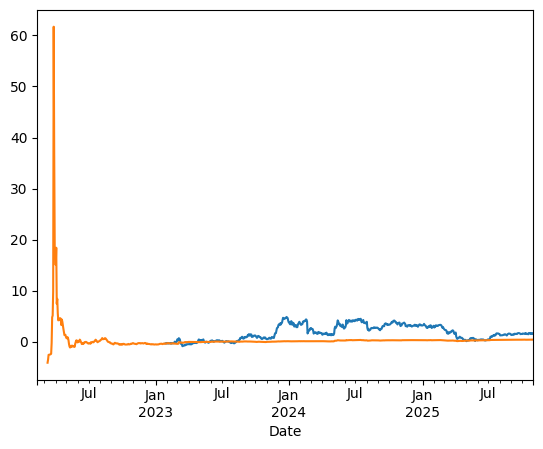

In [74]:
from src.assessments.calmar_ratio import CalmarRatio

calmar_ratio = CalmarRatio(config=config)
calmar_ratio.summary()
calmar_ratio.rolling().plot()
calmar_ratio.expanding().plot()

<Axes: xlabel='Date'>

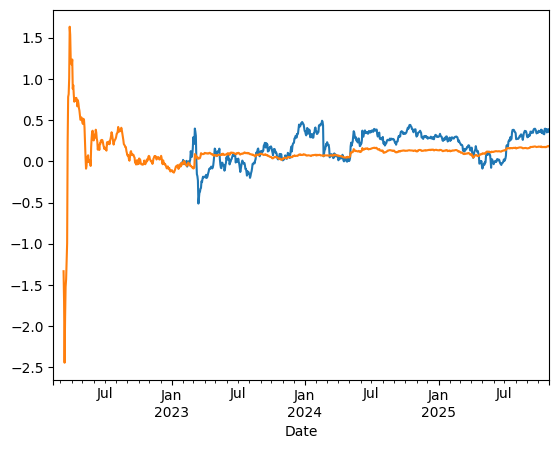

In [75]:
from src.assessments.treynor_ratio import TreynorRatio

treynor_ratio = TreynorRatio(config=config)
treynor_ratio.summary()
treynor_ratio.rolling().plot()
treynor_ratio.expanding().plot()

<Axes: xlabel='Date'>

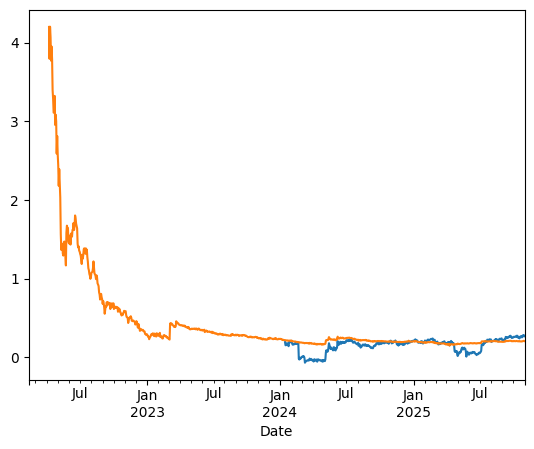

In [76]:
from src.assessments.jensens_alpha import JensensAlpha

jensens_alpha = JensensAlpha(config=config)
jensens_alpha.summary()
jensens_alpha.rolling().plot()
jensens_alpha.expanding().plot()

<Axes: xlabel='Date'>

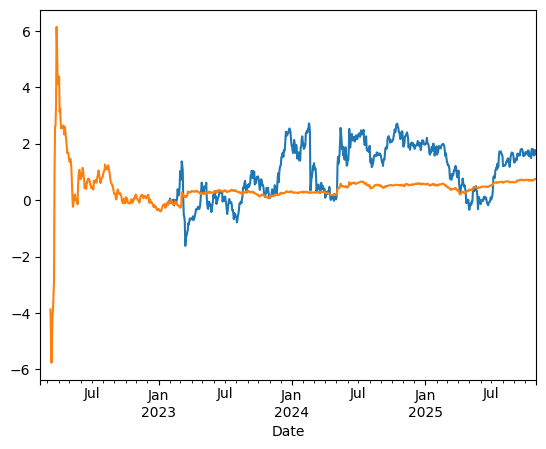

In [77]:
from src.assessments.sortino_ratio import SortinoRatio

sortino_ratio = SortinoRatio(config=config)
sortino_ratio.summary()
sortino_ratio.rolling().plot()
sortino_ratio.expanding().plot()

In [78]:
e = Evaluation(config=config)
e.run()
e.timer()

# e._initialized_assessments["Beta"].timer.df

,Assessment,Type,Time (s)
0,Beta,summary,0.000154
1,Beta,rolling,0.000381
2,Beta,expanding,0.000434
3,CAGR,summary,0.000056
4,CAGR,rolling,0.001999
5,CAGR,expanding,0.002632
6,Max Drawdown,summary,0.000152
7,Max Drawdown,rolling,0.003919
8,Max Drawdown,expanding,0.007191
9,Tracking Error,summary,0.000076


In [79]:
from src.assessments.beta import Beta

b = Beta(config=config)
b.rolling()

Date
2022-02-10         NaN
2022-02-11         NaN
2022-02-14         NaN
2022-02-15         NaN
2022-02-16         NaN
                ...   
2025-10-27    0.665512
2025-10-28    0.664721
2025-10-29    0.664596
2025-10-30    0.668766
2025-10-31    0.668374
Freq: B, Length: 972, dtype: float64

In [80]:
from src.assessments.max_drawdown import MaxDrawdown

b = MaxDrawdown(config=config)
b.rolling()

Date
2022-02-10         NaN
2022-02-11         NaN
2022-02-14         NaN
2022-02-15         NaN
2022-02-16         NaN
                ...   
2025-10-27   -0.242314
2025-10-28   -0.242314
2025-10-29   -0.242314
2025-10-30   -0.242314
2025-10-31   -0.242314
Freq: B, Length: 972, dtype: float64

<Axes: xlabel='Date'>

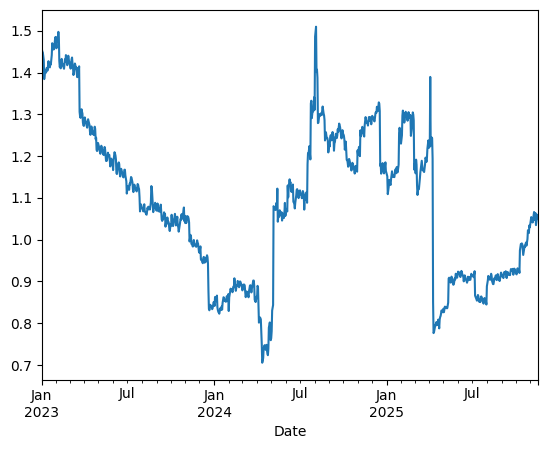

In [81]:
window = 252  # span for EWM

# Portfolio and benchmark returns
returns = holdings.twr
benchmark = bmk

# EWM covariance between portfolio and benchmark
cov_ewm = returns.ewm(span=window).cov(benchmark)

# EWM variance of benchmark
var_ewm = benchmark.ewm(span=window).var()

# EWMA beta
beta_ewm = cov_ewm / var_ewm
beta_ewm["2023":].plot()

<Axes: xlabel='Date'>

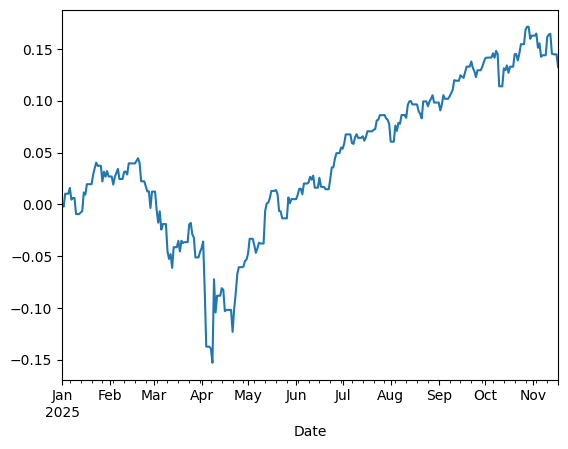

In [82]:
bmk["2025":].add(1).cumprod().sub(1).plot()

<Axes: xlabel='Date'>

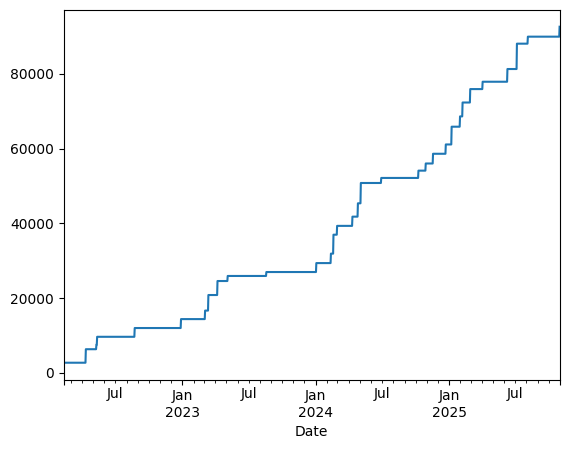

In [83]:
subscriptions.data["USD"].cumsum().plot()

In [84]:
from src.evaluation import Evaluation


e = Evaluation(config_active).with_assessments(
    # {AssessmentName.CAGR}
)
e.run()

Evaluation

In [85]:
e.display_timer_stats()

AttributeError: 'Evaluation' object has no attribute 'display_timer_stats'

In [ ]:
t = Ticker("ORCL")

In [ ]:
t.prices.resample("ME").last().pct_change().std() * 2

np.float64(0.1698097813140957)